<div class="alert alert-block alert-info">
    
## Table of Contents

</div>

[1. Introduction](#Intro) <br>
[2. Importing Libraries](#libs) <br>
[3. Loading Data](#data) <br>
[4. Task A](#taska) <br>
$\;\;\;\;$[4.1 Suburb](#suburb) <br>
$\;\;\;\;$[4.1 LGA](#lga) <br>
$\;\;\;\;$[4.3. Closest train station and it's distance](#close) <br>
$\;\;\;\;$[4.4. Direct Journey to Melbourne Central](#direct) <br>
$\;\;\;\;$[4.5. Minutes to Melbourne Central](#mins) <br>
$\;\;\;\;$[4.6. Web Scraping](#web) <br>


<div class="alert alert-block alert-success">
    
## 1.  Introduction  <a class="anchor" name="Intro"></a>

We will gather data from various files and employ web scraping techniques to extract additional information, which will be organized and presented in a visually appealing and easily understandable format.

<div class="alert alert-block alert-success">
    
## 2.  Importing Libraries  <a class="anchor" name="libs"></a>

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import PyPDF2
from math import radians, sin, cos, sqrt, atan2
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
from datetime import datetime, timedelta, time
from datetime import time
import time as t
import warnings
warnings.filterwarnings('ignore')
from urllib.parse import quote
from sklearn import preprocessing
import csv
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

<div class="alert alert-block alert-success">
    
## 3.  Loading Data  <a class="anchor" name="data"></a>

Prior to reading the XML file, I manually made an adjustment by inserting an extra opening tag "&lt;properties&gt;" at the beginning of the file and a closing tag "&lt;/properties&gt;" at the end of the file.    

Before:
<div>
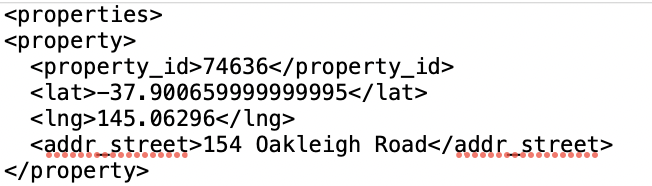
</div>


After:
<div>
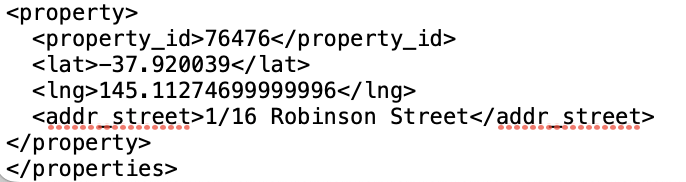
</div>

In [ ]:
# loading main data files 
xml_data = pd.read_xml("./32776705.xml")
json_data = pd.read_json("./32776705.json")

# loading shape file
suburb_boundaries = gpd.read_file("./Vic_suburb_boundary/VIC_LOCALITY_POLYGON_shp.shp")

# loading all GTFS data - might do this in the beginiing
agency = pd.read_csv("./Vic_GTFS_data/metropolitan/agency.txt")
calendar = pd.read_csv("./Vic_GTFS_data/metropolitan/calendar.txt")
calendar_dates = pd.read_csv("./Vic_GTFS_data/metropolitan/calendar_dates.txt")
routes = pd.read_csv("./Vic_GTFS_data/metropolitan/routes.txt")
shapes = pd.read_csv("./Vic_GTFS_data/metropolitan/shapes.txt")
stop_times = pd.read_csv("./Vic_GTFS_data/metropolitan/stop_times.txt")
stops = pd.read_csv("./Vic_GTFS_data/metropolitan/stops.txt")
trips = pd.read_csv("./Vic_GTFS_data/metropolitan/trips.txt")


<div class="alert alert-block alert-success">
    
## 4.  TASK A  <a class="anchor" name="taska"></a>

First we will prepare our basic data and go from there, for that we are joining our json and xml data...

In [ ]:
json_data.head()

We will check if there is any duplication in rows for the json_data.   
From the following code we will learn that there are 9 duplicated rows. 

In [ ]:
json_duplicates = json_data.duplicated()
json_duplicates.value_counts()

In [ ]:
# showing duplicated rows
duplicate_records_json = json_data[json_data.duplicated(keep = False)]
duplicate_records_json

From the above dataframes we can see all the duplicated records. For example: index 82 and index 913 have same values and so on.....  
Next, we will remove all the duplicated rows and then there will be total of 1225 unique records instead of 1234 records.

In [ ]:
json_data_new = json_data.drop_duplicates()
len(json_data_new)

Similarly, we will check if there is any duplication in rows for the xml_data.   
From the following code we will learn that there are 14 duplicated rows. 

In [ ]:
# loading xml file
xml_data.head()

In [ ]:
# calculating duplicated rows
xml_duplicates = xml_data.duplicated()
xml_duplicates.value_counts()

In [ ]:
# showing duplicated rows
duplicate_records_xml = xml_data[xml_data.duplicated(keep = False)]
duplicate_records_xml

From the above dataframes we can see all the duplicated records. For example: index 108 and index 495 have same values and so on.....  
Next, we will remove all the duplicated rows and then there will be total of 1215 unique records instead of 1229 records.

In [ ]:
xml_data_new = xml_data.drop_duplicates()
len(xml_data_new)

In [ ]:
# merging both dataframes 
data = pd.merge(xml_data_new, json_data_new, on=list(xml_data_new.columns), how='outer')

In [ ]:
len(data)

From the above we can make out that there were about 18(1215+1225-2422) common records, which were removed from the merged data. 

In [ ]:
data.head()

We will work with the above Dataframe and will add columns in the following code..

<div class="alert alert-block alert-info">
    
### 4.1. Suburb <a class="anchor" name="suburb"></a>

In [ ]:
suburb_list = []
for row in data.itertuples(index=False):
    
    # creating a point object
    point = Point(row.lng, row.lat)
    
    # checking if the point exists in suburb boundaries' geometry column
    suburb_match = suburb_boundaries[suburb_boundaries['geometry'].contains(point)]
    
    # suburb_match is true for any geometry value 
    if not suburb_match.empty :
        # getting suburb value and appending to the list 
        value = suburb_match['VIC_LOCA_2'].values[0] #getting first match
        suburb_list.append(value)
    # if no suburb match is found, i.e False, then value becomes NA
    else:
        value = "NA"
        continue

In [ ]:
# assigning suburb values to the data dataframe
data['suburb'] = suburb_list
data.head()

<div class="alert alert-block alert-info">
    
### 4.2. LGA <a class="anchor" name="lga"></a>

Now we are reading the Local Government Area pdf as a dataframe and creating a new lga column in the following code..

In [ ]:
def process_pdf(path):
    """
    Process a PDF file and create a DataFrame from key-value pairs.

    Parameters:
    - path (str): The path to the PDF file.

    Returns:
    - DataFrame: A Pandas DataFrame containing key-value pairs extracted from the PDF.
    """
    
    # Initializing empty dictionaries
    pdf_dict = {}   
    new_dict = {}  
    
    with open(path, 'rb') as file:
        # Creating a PDF reader object
        pdf_reader = PyPDF2.PdfReader(file)  
        num_pages = len(pdf_reader.pages) 
        
        for page_num in range(num_pages):  
            page = pdf_reader.pages[page_num]  
            text = page.extract_text()
            pdf_dict[page_num] = text 
            # Split the text into lines
            lines = text.split('\n')  
            for line in lines: 
                if ':' in line: 
                    # Split the line into key and value 
                    key, value = line.split(':')  
                    # Removing whitespaces from the key
                    key = key.strip()  
                    new_dict[key] = value.upper()  
                else:
                    continue
                    
    # returning a DataFrame from the new dictionary, using keys as index                    
    return pd.DataFrame.from_dict(new_dict, orient= 'index')


In [ ]:
lga_df = process_pdf('./Lga_to_suburb.pdf')  
# resetting index for the ease of coding 
lga_df.reset_index(inplace=True)
# renaming columns for the ease of coding
lga_df.rename(columns={"index": "lga_name", 0: "suburbs"}, inplace= True)
lga_df.head()

In [ ]:
# list to store lga results
lga_list = []
for data_idx, data_row in data.iterrows():
    # To track if a match is found
    match = False
    for lga_idx, lga_row in lga_df.iterrows():
        # Checking data.suburb is in lga_df.suburbs
        if data_row.suburb in lga_row.suburbs:
            lga_list.append(lga_row.lga_name)
            # Set the flag to indicate a match is found
            match = True
            break  
    if not match:
        lga_list.append("NA")  # Default value


In [ ]:
# assigning lga values to the data dataframe
data['lga'] = lga_list
data.head()

<div class="alert alert-block alert-info">
    
### 4.3. Closest train station and it's distance <a class="anchor" name="close"></a>

We will use stops data to calculate the distance between nearest train station and properties...  
nearest train station will be its stop id

In [ ]:
stops.head()

In [ ]:
def nearest_distance(lat1, lon1, lat2, lon2):
    
    '''
    Function to calculate the nearest distance between 2 points based on their latitudes and longitudes.
    Here, radius of Earth is assumed to be 6378 kms.
    
        Input Parameters:
            lat1: latitude value
            lon1: longitude value
            lat2: latitude value 
            lon2: longitude value
    
        Output:
            Distance between 2 points.
    '''
    
    # radius in Kms
    radius = 6378 

    #converting property latitudes and longitudes to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
   
    # calculating differences between latitudes and longitudes  
    lat_diff = lat2- lat1
    lon_diff = lon2 - lon1 
    
   # applying Haversine formula to calculate nearest distance
    a = sin(lat_diff / 2)**2 + cos(lat1) * cos(lat2) * sin(lon_diff / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = round(radius * c, 5)
    
    return distance

In [ ]:
# list of property locations as a tuple
property_locs = list(zip(data['lat'], data['lng']))
len(property_locs)

In [ ]:
# storing nearest station id  and its distance in 2 seperate lists
station_distance = []
nearest_station_id = []

for prop_lat, prop_lon in property_locs:
    min_dist = float('inf') # setting min distance to be the max known value
    nearest_station = None # Variable to store the nearest station ID
    # iterating over every row of stops df
    for idx, row in stops.iterrows():
        dist = nearest_distance(prop_lat, prop_lon, row['stop_lat'], row['stop_lon']) # calculating distance
        if dist < min_dist:
            min_dist = dist
            nearest_station = row['stop_id'] # Update the nearest station ID if a closer station is found
            
    station_distance.append(min_dist)
    nearest_station_id.append(nearest_station)

In [ ]:
# assigning suburb values to the data dataframe
data['closest_train_station_id'] = nearest_station_id
data['distance_to_closest_train_station'] = station_distance
data.head()

<div class="alert alert-block alert-info">
    
### 4.4. Direct Journey to Melbourne Central <a class="anchor" name="direct"></a>

In [ ]:
# trainnschedules
calendar.head()

We only need serivices that work on all weekdays...

In [ ]:
# filter by all weekdays only
calendar_filtered = calendar[(calendar['monday'] == 1) & (calendar['tuesday'] == 1) & (calendar['wednesday'] == 1) & (calendar['thursday'] == 1) & (calendar['friday'] == 1)]
reqd_service_ids = list(calendar_filtered['service_id'])
reqd_service_ids


Now there is only 1 service i.e T0 as opposed to 19 services earlier. Next, we will filter trip ids according to departure time.    
To perform date calculations accurately, it is essential for the column to be in datetime format. However, the departure time column is currently in string format. Therefore, we will begin by converting it to a datetime column to facilitate the calculations. 
  
  
<div>
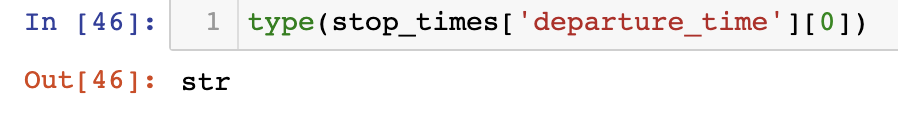
</div>


In [ ]:
# creating a function to convert str time to datetime format
def datetime_type(time_str):
    """
    Converts a time string into a datetime object.

    PARAMETERS:
        time_str (str): A time string in the format 'hours:minutes:seconds'.

    RETURNS:
        datetime.time: A datetime object representing the time.

    """
    # Splitting the time string into hours, minutes, and seconds
    hrs, mins, secs = map(int, time_str.split(':'))

    # Checking if hours exceed 24, formattin it.
    if hrs >= 24:
        hrs %= 24

    # Creating a timedelta object with the given hours, minutes, and seconds
    new_time = timedelta(hours=hrs, minutes=mins, seconds=secs)

    # datetime.time object - extracting the time component
    return (datetime.min + new_time).time()


In [ ]:
# creating a datetime column for departure time for calculations
stop_times['depart_time_dt'] = stop_times['departure_time'].apply(lambda x: datetime_type(x))

In [ ]:
# creating new time objects
start_time = time(7,0,0)
end_time = time(9,0,0)

In [ ]:
# filtering departure times and getting required trip IDs
stop_times_filtered = stop_times[(stop_times['depart_time_dt'] >= start_time) & (stop_times['depart_time_dt'] <= end_time)]
reqd_trip_ids = list(set(stop_times_filtered['trip_id']))

In [ ]:
# getting a dataframe from our required servuce ids, trip ids
filtered_df = trips[(trips['service_id'].isin(reqd_service_ids)) & (trips['trip_id'].isin(reqd_trip_ids))]
filtered_df.head()

In [ ]:
# getting a dataframe with all required information
depart_weekdays_filter_df = pd.merge(filtered_df, stop_times, on='trip_id', how='left')
depart_weekdays_filter_df.drop(columns =["direction_id", "stop_headsign", "pickup_type", "drop_off_type", "shape_dist_traveled"], inplace =True)
depart_weekdays_filter_df.head()

The above dataframe gives us all the information about trips that fit to our description, i.e:  
* Works on all weekdays.   
* Departs between 7-9 AM. 
  
To identify direct trips to Melbourne Central, we will search for all trips that include a stop ID corresponding to Melbourne Central. We will then merge this information with the previously mentioned data. Next, we will examine the stop sequence column to determine if these trips are heading towards Melbourne Central or not.

In [ ]:
# getting melbourne central stop id 
mc_stop_id = stops.loc[stops['stop_name'] == "Melbourne Central Railway Station", 'stop_id'].values[0]
mc_stop_id

In [ ]:
# Subsetting stop_times for stop_id = mc_stop_id
mc_stops = stop_times[stop_times['stop_id'] == mc_stop_id]

Finally, creating a new dataframe by combining the above dataframe (final destination dataframe) with the one we got after all the filteration process. We will preform an inner join to get all the trip ids which are travelling towards Melbourne Central Railway station on all weekdays between 7-9AM.

In [ ]:
# creating a new dataframe by combining the above and the dataframe 
conditioned_df = pd.merge(depart_weekdays_filter_df, mc_stops,on ="trip_id", how ="inner")
conditioned_df.head()

Currently, we are retaining a DataFrame that includes rows where the stop ID(x, origin stop_id) is equal to the Melbourne Central stop ID or where the stop sequence(x, i.e origin stop) is less than the stop sequence y (destination). This condition indicates that the train is traveling towards the Melbourne Central Railway Station. that signifies that train is travelling towards Melbourne Central Railway  Station.

In [ ]:
# keeping stop ids with
direct_flag_df = conditioned_df[(conditioned_df['stop_id_x'] == mc_stop_id) | (conditioned_df['stop_sequence_x'] < conditioned_df['stop_sequence_y'])]
direct_flag_df.head()

In [ ]:
# adding direct_journey_flag 
data['direct_journey_flag'] = [1 if row.closest_train_station_id in direct_flag_df['stop_id_x'].tolist() else 0 for row in data.itertuples(index=False)]
data.head()

<div class="alert alert-block alert-info">
    
### 4.5. Minutes to Melbourne Central <a class="anchor" name="mins"></a>

Working with the above Dataframe for calculating travel_min_to_MC column
    

In [ ]:
# converting arrival time to datetime.time format for further calculations 
direct_flag_df.loc[:, 'arrival_time_y_dt'] = direct_flag_df['arrival_time_y'].apply(lambda x: datetime_type(x))

# converting datetime.time to datetime.datetime objects. can replace month, year, adate with any valid value
direct_flag_df['trip_start_datetime'] = pd.to_datetime(direct_flag_df['depart_time_dt_x'], format='%H:%M:%S').apply(lambda x: x.replace(year=2023, month=1, day=1))
direct_flag_df['trip_end_datetime'] = pd.to_datetime(direct_flag_df['arrival_time_y_dt'], format='%H:%M:%S').apply(lambda x: x.replace(year=2023, month=1, day=1))

# calculating the time it takes for the journey in minutes ( from any stop to Melbourne Central)
direct_flag_df['time_difference_minutes'] = (direct_flag_df['trip_end_datetime'] - direct_flag_df['trip_start_datetime']).dt.total_seconds() / 60

direct_flag_df.head()

In [ ]:
avg_time = direct_flag_df.groupby('stop_id_x')['time_difference_minutes'].mean().round().reset_index()
avg_time.head()

In [ ]:
# adding travel_min_to_MC to the data 
new_data = pd.merge(data, avg_time, left_on = "closest_train_station_id", right_on ="stop_id_x", how ="left")
# filling na values after merge
new_data['time_difference_minutes'] = new_data['time_difference_minutes'].fillna("no direct trip is available")
# dropping extra columns
new_data.drop(columns =["stop_id_x"], inplace= True)
# changing column names
new_data = new_data.rename(columns={'time_difference_minutes': 'travel_min_to_MC'})
new_data.head()

<div class="alert alert-block alert-info">
    
### 4.6. Web Scraping <a class="anchor" name="web"></a>

We need to perform webscraping to extract rest of the columns. Lets begin by extracting all suburbs from our data dataframe. 
<div>
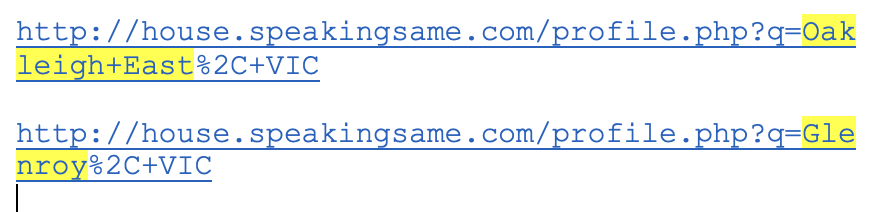
</div>


If we carefully analyze the above 2 links, we will see just the highlighted part changes.....

In [ ]:
# creating a dataframe with suburb and their link 
suburb_link_df = pd.DataFrame({'suburb':list(set(new_data.suburb))})

# for getting links
pre = "http://house.speakingsame.com/profile.php?q="
post = "%2C+VIC"

# adding link column
suburb_link_df['link'] = suburb_link_df['suburb'].apply(lambda x: pre + quote(x) + post)

In [ ]:
# creating a function to extract information of suburbs 
def td_info(list_of_links, csv_file_path):
    """
    Retrieves information from HTML pages based on the provided links and saves the data into a CSV file.
    
    Parameters:
        list_of_links (list): A list of URLs to HTML pages.
        csv_file_path (str): File path to save the resulting CSV file.
    """
    
    for link in list_of_links:
        # Retrieve the HTML content of the page
        html = requests.get(link).text
        # Create a BeautifulSoup object to parse the HTML
        bsobj = BeautifulSoup(html, 'html.parser')
        
        # Find the Number of houses/units table data
        houses_units = bsobj.find('td', text='Number of houses/units')

        if houses_units:
            # Extract the number of houses and units
            no_of_houses, no_of_units = houses_units.find_next('td').find_next('td').text.split(" / ")
        else:
            # If information is not found, assign 'NA'
            no_of_houses = 'NA'
            no_of_units = 'NA'

        # Find the Municipality table data
        municipality_name = bsobj.find('td', text='Municipality')
        if municipality_name:
            # Extract the municipality name
            mun = municipality_name.find_next('td').find_next('td').text
        else:
            # If information is not found, assign 'NA'
            mun = 'NA'

        # Find the Australian Born percentage table data
        aus_born_perc = bsobj.find('td', text='Australian Born')
        if aus_born_perc:
            # Extract the percentage of Australian-born population
            abp = aus_born_perc.find_next('td').text
        else:
            # If information is not found, assign 'NA'
            abp = 'NA'

        # Find the Weekly income table data
        median_income = bsobj.find('td', text='Weekly income')
        if median_income:
            # Extract the median income
            med_inc = median_income.find_next('td').text
        else:
            # If information is not found, assign 'NA'
            med_inc = 'NA'

        # Find the Median house price 
        median_house_price = bsobj.find('td', text='House')
        if median_house_price:
            # Extract the median house price
            med_price = median_house_price.find_next('td').text
        else:
            # If information is not found, assign 'NA'
            med_price = 'NA'

        # Find the Population of the suburb 
        population = bsobj.find('td', text='All People')
        if population:
            # Extract the population count
            pop = population.find_next('td').text
        else:
            # If information is not found, assign 'NA'
            pop = 'NA'

        # Prepare the data to be appended to the CSV file
        append_data = [1, link, no_of_houses, no_of_units, mun, abp, med_inc, med_price, pop]
        with open(csv_file_path, 'a') as f:
            # Create the csv writer
            writer = csv.writer(f)
            
            # Write a row to the csv file
            writer.writerow(append_data)


In [ ]:
# creating an empty csv file
dummy_df = pd.DataFrame(columns =['link','number_of_houses', 'number_of_units', 'municipality', 'aus_born_perc','median_income','median_house_price', 'population'])
dummy_df.to_csv('scrapped_info.csv')

In [ ]:
# we will create batches of 45 links for web scraping
size = 45
links_list = list(suburb_link_df['link'])
link_batches = [links_list[i:i+size] for i in range(0, len(links_list), size)]

# Initialize counter variables
counter = 0
max_counter = len(link_batches)
for batch in link_batches:
    counter += 1
     
    # Scrape information from the batch of links and append it to the CSV file
    td_info(batch, './scrapped_info.csv')
    
    # Check if it is the last batch
    if counter == max_counter:
        break
        
    else:
        # Wait for 10 minutes before processing the next batch
        t.sleep(600)
        continue    

In [ ]:
# importing the web-scrapped data from previous steps 
scrapped_data = pd.read_csv("./scrapped_info.csv")
# removing unnecessary columns 
scrapped_data.drop(['Unnamed: 0'],axis=1, inplace=True)
scrapped_data.head()

9/10 the above web scraping code gives us the correct output. Sometimes it outputs duplicated rows. To avoid duplication we will remove all duplicatedrows just in case. 

In [ ]:
# dropping duplicates just in case
scrapped_data = scrapped_data.drop_duplicates()

In [ ]:
# changing datatype of columns 
scrapped_data['number_of_houses'] = scrapped_data['number_of_houses'].astype(float)
scrapped_data['number_of_units'] = scrapped_data['number_of_units'].astype(float)
scrapped_data['population'] = scrapped_data['population'].astype(float)

scrapped_data.head()

In [ ]:
# we will merge scrapped data with suburb_link_df to get suburb column and will then merge it with our new_data df
helper_df = pd.merge(scrapped_data, suburb_link_df, on ="link", how ="inner")
taska_df = pd.merge(new_data, helper_df, on = "suburb", how = "left")

# droppinf extra link column
taska_df.drop(['link'],axis=1, inplace=True)

In [ ]:
taska_df.head()

In [ ]:
# checking all datatypes
taska_df.dtypes

In [ ]:
# export to csv
taska_df.to_csv("./taska_df.csv")